# SCMA 632. Statistical Analysis and Modelling - FINAL EXAM
# SECTION B - PART B - SATHWIK NAG C V

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [6]:
# Load the data
df = pd.read_excel('G:\\VCU\\Bootcamp Assignment\\A6\A6b\\pinksheet.xlsx', skiprows=6, sheet_name='Monthly Prices')

In [7]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [8]:
# Convert the Date column to datetime format
def parse_date(date_str):
    # Split the string by 'M' to separate year and month
    year, month = date_str.split('M')
    # Create a date string in the format 'YYYY-MM-01'
    return f"{year}-{month}-01"

df['Date'] = pd.to_datetime(df['Date'].apply(parse_date))

# Print the data types to confirm the conversion
print(df.dtypes)

Date           datetime64[ns]
CRUDE_PETRO           float64
CRUDE_BRENT           float64
CRUDE_DUBAI           float64
CRUDE_WTI              object
                    ...      
NICKEL                float64
Zinc                  float64
GOLD                  float64
PLATINUM              float64
SILVER                float64
Length: 72, dtype: object


In [9]:
# Select specific columns (Date and selected commodities)
commodity = df.iloc[:, [0, 2, 24, 69, 71, 60, 30]]
commodity.columns = [col.lower().replace(' ', '_') for col in commodity.columns]  # Clean column names

print(commodity.dtypes)

date            datetime64[ns]
crude_brent            float64
soybeans               float64
gold                   float64
silver                 float64
urea_ee_bulk           float64
maize                  float64
dtype: object


In [10]:
# Remove the Date column for analysis
commodity_data = commodity.drop(columns=['date'])

# Column names to test
columns_to_test = commodity_data.columns

In [11]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [12]:
# Loop through each column and perform the ADF test
for col in columns_to_test:
    adf_result = adfuller(commodity_data[col])
    p_value = adf_result[1]  # Extract p-value for the test
    print(f"\nADF test result for column: {col}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {p_value}")
    
    # Check if the p-value is greater than 0.05 (commonly used threshold)
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)


ADF test result for column: crude_brent
ADF Statistic: -1.5078661910935343
p-value: 0.5296165197702398

ADF test result for column: soybeans
ADF Statistic: -2.42314645274189
p-value: 0.13530977427790403

ADF test result for column: gold
ADF Statistic: 1.3430517021933006
p-value: 0.9968394353612382

ADF test result for column: silver
ADF Statistic: -1.397294710746222
p-value: 0.5835723787985764

ADF test result for column: urea_ee_bulk
ADF Statistic: -2.5101716315209086
p-value: 0.11301903181624645

ADF test result for column: maize
ADF Statistic: -2.4700451060920425
p-value: 0.12293380919376751


In [13]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}")
print(f"Non-stationary columns: {non_stationary_columns}")
print(f"Stationary columns: {stationary_columns}")


Number of non-stationary columns: 6
Non-stationary columns: ['crude_brent', 'soybeans', 'gold', 'silver', 'urea_ee_bulk', 'maize']
Stationary columns: []


In [14]:
# Co-Integration Test (Johansen's Test)
def johansen_test(df, alpha=0.05):
    out = coint_johansen(df, det_order=0, k_ar_diff=1)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]
    print(f"Trace statistic: {traces}")
    print(f"Critical values: {cvts}")
    print(f"Eigenvalues: {out.eig}")
    for col, trace, cvt in zip(df.columns, traces, cvts):
        if trace > cvt:
            print(f"{col} is cointegrated.")
        else:
            print(f"{col} is not cointegrated.")
    return out

In [15]:
# Perform Johansen cointegration test
coint_test = johansen_test(commodity_data)

Trace statistic: [261.5548149  167.67790177  98.11781369  53.4617083   21.6404865
   4.01416422]
Critical values: [95.7542 69.8189 47.8545 29.7961 15.4943  3.8415]
Eigenvalues: [0.11449947 0.08616362 0.05620349 0.04038124 0.02257335 0.0051862 ]
crude_brent is cointegrated.
soybeans is cointegrated.
gold is cointegrated.
silver is cointegrated.
urea_ee_bulk is cointegrated.
maize is cointegrated.


# The Johansen cointegration test has found significant long-term relationships among the commodity prices we tested, indicating that these commodities do not drift apart indefinitely but rather move together in the long run. This information can be crucial for developing trading strategies, risk management, and portfolio diversification in financial markets.

In [16]:
# Number of cointegrating relationships (assuming r = 1 if there's at least one significant eigenvalue)
r = sum(coint_test.lr1 > coint_test.cvt[:, 1])  # Replace with the actual number from the test results

In [17]:
df.columns

Index(['Date', 'CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'CRUDE_WTI',
       'COAL_AUS', 'COAL_SAFRICA', 'NGAS_US', 'NGAS_EUR', 'NGAS_JP', 'iNATGAS',
       'COCOA', 'COFFEE_ARABIC', 'COFFEE_ROBUS', 'TEA_AVG', 'TEA_COLOMBO',
       'TEA_KOLKATA', 'TEA_MOMBASA', 'COCONUT_OIL', 'GRNUT', 'FISH_MEAL',
       'GRNUT_OIL', 'PALM_OIL', 'PLMKRNL_OIL', 'SOYBEANS', 'SOYBEAN_OIL',
       'SOYBEAN_MEAL', 'RAPESEED_OIL', 'SUNFLOWER_OIL', 'BARLEY', 'MAIZE',
       'SORGHUM', 'RICE_05', 'RICE_25', 'RICE_A1', 'RICE_05_VNM',
       'WHEAT_US_SRW', 'WHEAT_US_HRW', 'BANANA_EU', 'BANANA_US', 'ORANGE',
       'BEEF', 'CHICKEN', 'LAMB', 'SHRIMP_MEX', 'SUGAR_EU', 'SUGAR_US',
       'SUGAR_WLD', 'TOBAC_US', 'LOGS_CMR', 'LOGS_MYS', 'SAWNWD_CMR',
       'SAWNWD_MYS', 'PLYWOOD', 'COTTON_A_INDX', 'RUBBER_TSR20',
       'RUBBER1_MYSG', 'PHOSROCK', 'DAP', 'TSP', 'UREA_EE_BULK', 'POTASH',
       'ALUMINUM', 'IRON_ORE', 'COPPER', 'LEAD', 'Tin', 'NICKEL', 'Zinc',
       'GOLD', 'PLATINUM', 'SILVER'],
      dtype='o

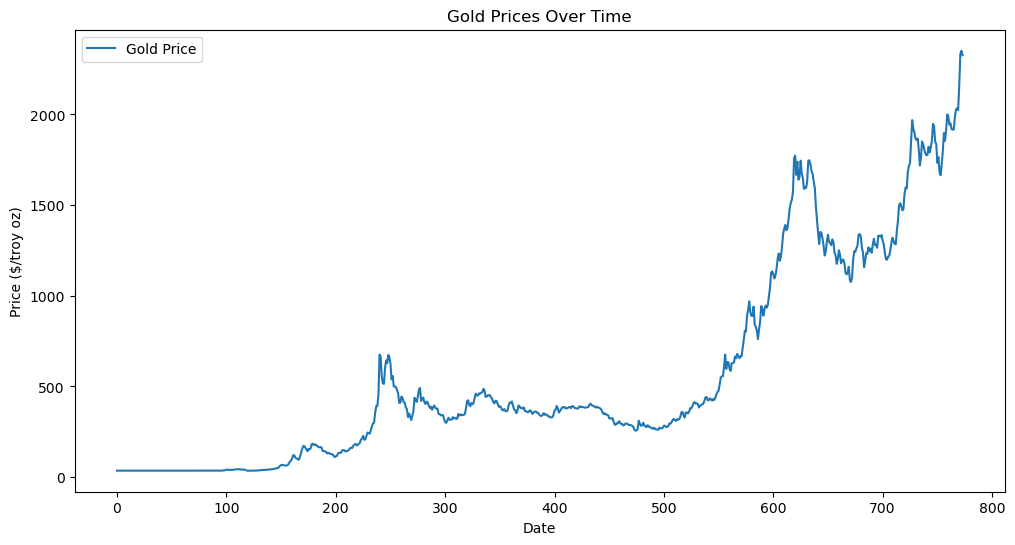

In [18]:
# Extract 'GOLD' column
gold_data = df['GOLD']

# Plot gold prices
plt.figure(figsize=(12, 6))
plt.plot(gold_data.index, gold_data, label='Gold Price')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [19]:
# Split data into train and test sets
train_size = int(len(gold_data) * 0.8)
train, test = gold_data[:train_size], gold_data[train_size:]

print("Training data size:", len(train))
print("Test data size:", len(test))

Training data size: 619
Test data size: 155


# Fit SARIMA Model

In [20]:
# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

In [21]:
# Forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test))
sarima_forecast_index = test.index
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_conf_int = sarima_forecast.conf_int()

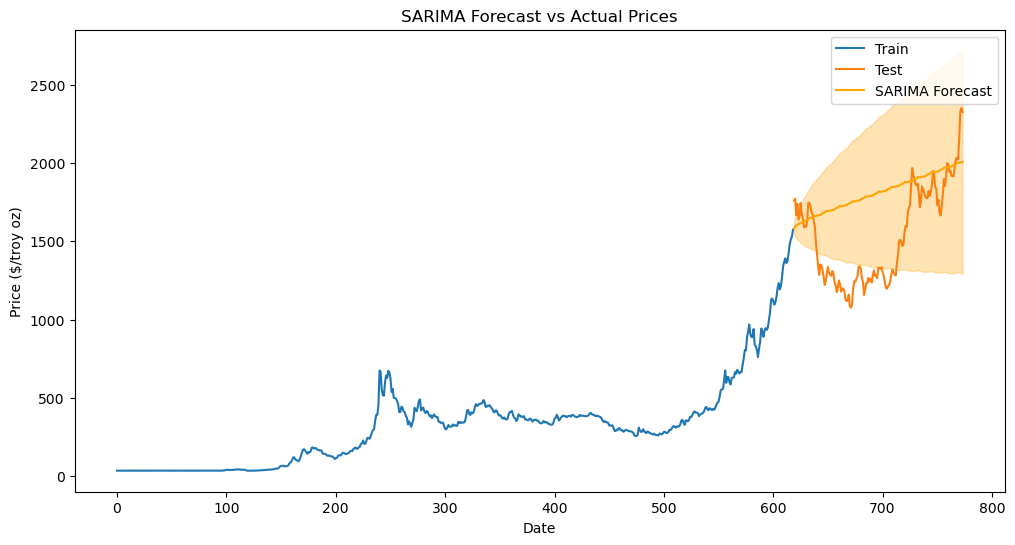

In [22]:
# Plot SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(sarima_forecast_index, sarima_forecast_mean, label='SARIMA Forecast', color='orange')
plt.fill_between(sarima_forecast_index, sarima_forecast_conf_int.iloc[:, 0], sarima_forecast_conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [23]:
# Evaluation metrics
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast_mean))
sarima_mape = np.mean(np.abs((test - sarima_forecast_mean) / test)) * 100
sarima_mae = mean_absolute_error(test, sarima_forecast_mean)

print(f'SARIMA RMSE: {sarima_rmse}')
print(f'SARIMA MAPE: {sarima_mape}')
print(f'SARIMA MAE: {sarima_mae}')

SARIMA RMSE: 375.3057210959555
SARIMA MAPE: 23.37585887675557
SARIMA MAE: 308.7535917515804


# Forecast Quality Metrics - SARIMA model

RMSE (Root Mean Squared Error) = 375.31: This metric measures the average magnitude of the error by squaring the differences between predicted values and actual values. The square root of the average of these squares gives us RMSE. A value of 375.31 is relatively high, suggesting that the forecast often deviates from the actual values by a substantial margin, which is consistent with the observed spikes that the model missed.

MAPE (Mean Absolute Percentage Error) = 23.38%: This indicates that the predictions are off by 23.38% from the actual values on average, which points to a considerable error rate relative to the price levels. This high percentage error reflects the model’s challenges in dealing with the commodity’s price volatility.

MAE (Mean Absolute Error) = 308.75: Similar to RMSE but measures the average absolute errors without squaring them, providing a clearer representation of average error magnitude. An MAE of 308.75 suggests that the model has significant average absolute errors in forecasting the prices.

# The SARIMA model, while capturing the general trend, shows limited effectiveness in accurately predicting the price due to significant forecast errors (as seen from RMSE, MAPE, and MAE) and its inability to capture the more volatile swings in price observed in the test data. Improvements might be needed, either by tuning the model parameters, incorporating exogenous variables, or considering a different modeling approach to better handle the apparent volatility and non-linear trends in the data.

# Fit LSTM Model

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [25]:
# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 12
train_values = train.values
test_values = test.values

In [26]:
X_train, Y_train = create_dataset(train_values, look_back)
X_test, Y_test = create_dataset(test_values, look_back)

In [27]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [28]:
# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Train model
lstm_model.fit(X_train, Y_train, epochs=50, verbose=0)

In [30]:
# Forecast
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = np.reshape(lstm_forecast, (lstm_forecast.shape[0]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


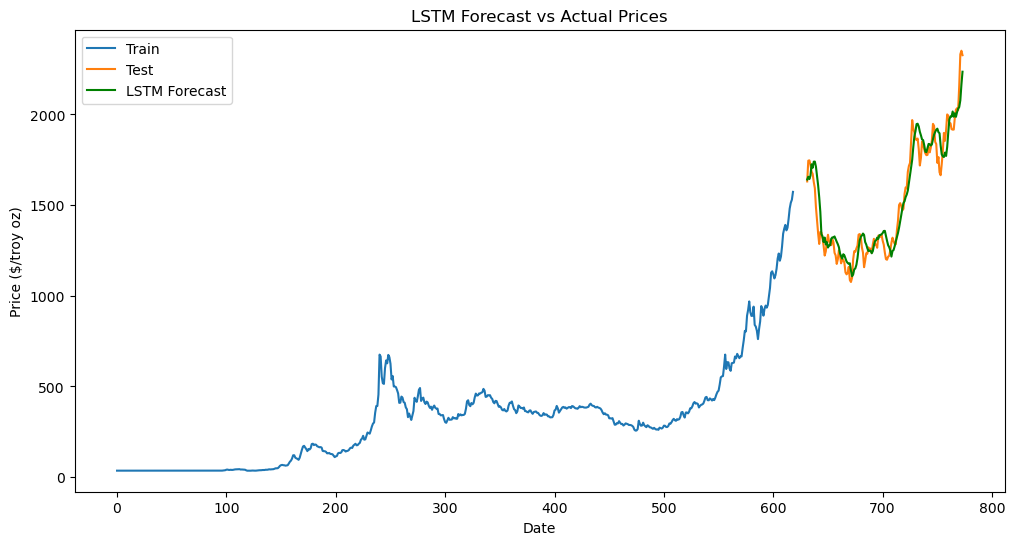

In [31]:
# Plot LSTM Forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index[look_back:], test[look_back:], label='Test')
plt.plot(test.index[look_back:], lstm_forecast, label='LSTM Forecast', color='green')
plt.title('LSTM Forecast vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [32]:
# Evaluation metrics
lstm_rmse = np.sqrt(mean_squared_error(test[look_back:], lstm_forecast))
lstm_mape = np.mean(np.abs((test[look_back:] - lstm_forecast) / test[look_back:])) * 100
lstm_mae = mean_absolute_error(test[look_back:], lstm_forecast)

print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM MAPE: {lstm_mape}')
print(f'LSTM MAE: {lstm_mae}')

LSTM RMSE: 91.5739029108088
LSTM MAPE: 4.608634507865815
LSTM MAE: 69.66896196301283


# Forecast Quality Metrics - LSTM model

RMSE (Root Mean Squared Error) = 91.57: This value measures the average magnitude of the errors between predicted and actual values, squared to avoid cancellation of opposing errors. An RMSE of 91.57, while indicating some errors, is considerably lower than the one noted for the SARIMA model previously discussed, suggesting a more accurate forecast in this case.

MAPE (Mean Absolute Percentage Error) = 4.61%: This metric shows that, on average, the model's predictions are off by about 4.61% from the actual values. This percentage is much lower than that of the SARIMA model, indicating a high level of accuracy relative to the price levels and demonstrating the model's effectiveness in capturing price dynamics.

MAE (Mean Absolute Error) = 69.67: Measures the average absolute difference between the forecasted and actual values, providing a straightforward indication of error magnitude without squaring the results. An MAE of 69.67 further confirms the model’s accuracy in forecasting, as it suggests a relatively low average error per forecast point.

# The LSTM model has demonstrated a strong capability in modeling and forecasting the commodity prices accurately, capturing both the long-term trends and short-term fluctuations effectively. The metrics—especially the much lower RMSE and MAPE compared to those from the SARIMA model—suggest that the LSTM is quite adept at handling the non-linear and complex patterns inherent in financial time series data like commodity prices.